Loading relevant packages

In [9]:
import requests
import json
from json import loads
import pandas as pd
from datetime import datetime
import time
import loading
import util
import processing
import importlib
importlib.reload(loading)
importlib.reload(util)
importlib.reload(processing)

<module 'processing' from '/Users/jeremyelvander/STA-141B-Final-Project/processing.py'>

Using BART API to find relevant station information (Station name, Lattitude & Longitude for mapping)

In [3]:
df = loading.stationLoad(["San Francisco", "Oakland"])


In [ ]:
df

,city,name,gtfs_latitude,gtfs_longitude
0,Oakland,12th St. Oakland City Center,37.803768,-122.271450
1,Oakland,Oakland International Airport,37.713238,-122.212191
2,Oakland,MacArthur,37.829065,-122.267040
3,Oakland,Lake Merritt,37.797027,-122.265180
4,Oakland,Rockridge,37.844702,-122.251371
5,Oakland,Coliseum,37.753661,-122.196869
6,Oakland,Fruitvale,37.774836,-122.224175
7,Oakland,19th St. Oakland,37.808350,-122.268602
8,Oakland,West Oakland,37.804872,-122.295140
9,San Francisco,Embarcadero,37.792874,-122.397020


In [4]:

dct = util.dfToDict(df, 'name', ['gtfs_latitude', 'gtfs_longitude'], groupby = 'city')
print(dct)
dct['San Francisco']['Balboa Park']

{'Oakland': {'12th St. Oakland City Center': [37.803768, -122.27145], '19th St. Oakland': [37.80835, -122.268602], 'Coliseum': [37.753661, -122.196869], 'Fruitvale': [37.774836, -122.224175], 'Lake Merritt': [37.797027, -122.26518], 'MacArthur': [37.829065, -122.26704], 'Oakland International Airport': [37.713238, -122.212191], 'Rockridge': [37.844702, -122.251371], 'West Oakland': [37.804872, -122.29514]}, 'San Francisco': {'16th St. Mission': [37.765062, -122.419694], '24th St. Mission': [37.75247, -122.418143], 'Balboa Park': [37.721585, -122.447506], 'Civic Center/UN Plaza': [37.779732, -122.414123], 'Embarcadero': [37.792874, -122.39702], 'Glen Park': [37.733064, -122.433817], 'Montgomery St.': [37.789405, -122.401066], 'Powell St.': [37.784471, -122.407974]}}


[37.721585, -122.447506]

In [5]:
secretKey = '1ef8dner8br348ez190z3z188a6pm1yluwh2wcj4xjjnlvupe'
key = '523e7ewewudxb1frvbmdftwdt'

In [59]:
importlib.reload(processing)
importlib.reload(util)
queriesSF = [
            ['SF', dct['San Francisco']['Balboa Park'], 0.25, 2021, 1000, 0],
             ['SF', dct['San Francisco']['Embarcadero'], 0.25, 2021, 1000, 0],
             ['SF', dct['San Francisco']['Glen Park'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Civic Center/UN Plaza'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['24th St. Mission'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Montgomery St.'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['16th St. Mission'], 0.25, 2021, 1000, 0],
            ['SF', dct['San Francisco']['Powell St.'], 0.25, 2021, 1000, 0]]

metaSF = [
    [['incident_category', "SF"],
    ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
    ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Balboa Park"},
    ["San Francisco", "Balboa Park", dct]],
 [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Embarcadero"},
    ["San Francisco", "Embarcadero", dct]],
[['incident_category', "SF"],
["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Glen Park"},
    ["San Francisco", "Glen Park", dct]],
 [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Civic Center/UN Plaza"},
    ["San Francisco", "Civic Center/UN Plaza", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "24th St. Mission"},
    ["San Francisco", "24th St. Mission", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Montgomery St."},
    ["San Francisco", "Montgomery St.", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "16th St. Mission"},
    ["San Francisco", "16th St. Mission", dct]],
    [['incident_category', "SF"],
  ["incident_datetime"],
    ['point', ['longitude', 'latitude'], 'coordinates', True],
        ['incident_datetime', ['date', 'time'], 'T', True],
    {"city": "San Francisco", "station": "Powell St."},
    ["San Francisco", "Powell St.", dct]]
]

subprocessesSF = [
    util.isViolent, 
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesSF)

queriesOAK = [
             ['OAK', dct['Oakland']['Fruitvale'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['Rockridge'], 0.25, 2021, 1000, 0],
             ['OAK', dct['Oakland']['MacArthur'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Coliseum'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['12th St. Oakland City Center'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Oakland International Airport'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['Lake Merritt'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['19th St. Oakland'], 0.25, 2021, 1000, 0],
            ['OAK', dct['Oakland']['West Oakland'], 0.25, 2021, 1000, 0]
            ]

metaOAK = [
    [
        ['description', "OAK"],
    ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
        ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Fruitvale"},
    ["Oakland", "Fruitvale", dct]],
 [
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Rockridge"},
    ["Oakland", "Rockridge", dct]],
[
    ['description', "OAK"],
["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "MacArthur"},
    ["Oakland", "MacArthur", dct]],
 [
     ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Coliseum"},
    ["Oakland", "Coliseum", dct]],
    [
    ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "12th St. Oakland City Center"},
    ["Oakland", "12th St. Oakland City Center", dct]],
    [
        ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Oakland International Airport"},
    ["Oakland", "Oakland International Airport", dct]],
    [
    ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "Lake Merritt"},
    ["Oakland", "Lake Merritt", dct]],
    [
        ['description', 'OAK'],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "19th St. Oakland"},
    ["Oakland", "19th St. Oakland", dct]],
    [
        ['description', "OAK"],
  ["datetime"],
    ['location', ['longitude', 'latitude'], 'coordinates', True],
            ['datetime', ['date', 'time'], 'T', True],
    {"city": "Oakland", "station": "West Oakland"},
    ["Oakland", "West Oakland", dct]]
]

subprocessesOAK = [
    util.isViolent, 
    util.dayOrNight,
    util.splitColumnsJSON,
    util.splitColumnsJSON,
    util.addColumnsJSON,
    util.radius] * len(queriesOAK)

processes = [
    [processing.parallelProcess, [10, loading.loadCrime, queriesSF, 
                                       'load', True, None, subprocessesSF,
                                       metaSF, key, secretKey]],
    [processing.parallelProcess, [10, loading.loadCrime, queriesOAK, 
                                       'load', True, None, subprocessesOAK,
                                       metaOAK, key, secretKey]]
]

In [60]:

results = processing.multiParallelProcess(2, processes)

Time taken to process (seconds): 44.755516052246094
Time taken to process (seconds): 110.60977101325989


In [61]:
display(results[0][0].sample(5))
display(results[1][0].sample(5))

,incident_category,isViolent,night,longitude,latitude,date,time,city,station,distance
24487,Other Miscellaneous,False,False,-122.414741,37.778719,2023-10-09,18:13:00.000,San Francisco,Civic Center/UN Plaza,0.056843
5697,Non-Criminal,False,False,-122.396690,37.790462,2024-06-29,14:30:00.000,San Francisco,Embarcadero,0.092132
13703,Robbery,True,True,-122.414054,37.782794,2022-03-25,01:52:00.000,San Francisco,Civic Center/UN Plaza,0.113524
61970,Larceny Theft,False,False,-122.403712,37.784044,2022-02-20,12:35:00.000,San Francisco,Powell St.,0.294919
37207,Motor Vehicle Theft,False,False,-122.415321,37.754032,2024-07-27,21:00:00.000,San Francisco,24th St. Mission,0.203364


,description,isViolent,night,longitude,latitude,date,time,city,station,distance
23621,burglary auto,False,False,-122.26687,37.81127,2023-11-15,20:15:00.000,Oakland,19th St. Oakland,0.161006
1672,burglary forcible entry,False,False,-122.22415,37.77715,2023-08-08,23:30:00.000,Oakland,Fruitvale,0.085273
12010,vandalism,False,False,-122.27442,37.80131,2023-03-27,17:30:00.000,Oakland,12th St. Oakland City Center,0.224353
16479,vehicle theft auto,False,False,-122.26415,37.79728,2023-12-15,09:40:00.000,Oakland,Lake Merritt,0.071776
15239,burglary auto,False,False,-122.26491,37.80014,2021-10-28,21:00:00.000,Oakland,Lake Merritt,0.116328


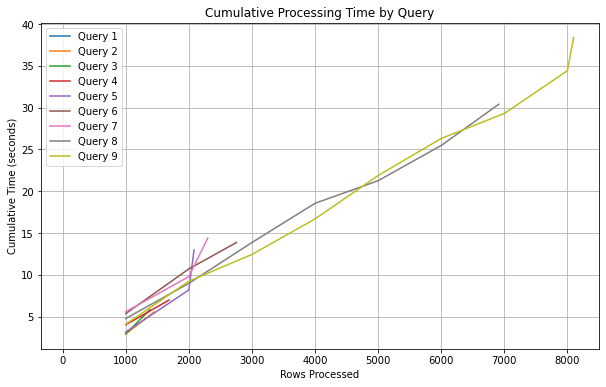

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

# Sample data
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = results[1][1]

# Number of queries
num_queries = len(data)

# Initialize storage for cumulative times and rows processed
cumulative_times = []
cumulative_rows = []

# Process each query
for query in data:
    # Extract processing times and rows processed for this query
    times = [entry[0] for entry in query]
    rows = [entry[1] for entry in query]

    # Calculate cumulative time and rows
    cumulative_times.append(np.cumsum(times))
    cumulative_rows.append(np.cumsum(rows))

# Plotting
plt.figure(figsize=(10, 6))

# Plot cumulative time for each query
for query_idx in range(num_queries):
    plt.plot(cumulative_rows[query_idx], cumulative_times[query_idx], label=f"Query {query_idx + 1}")

# Add labels, legend, and grid
plt.title("Cumulative Processing Time by Query")
plt.xlabel("Rows Processed")
plt.ylabel("Cumulative Time (seconds)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [75]:
names = {"incident_datetime": "datetime", "incident_category": "crime", "description": "crime"}
sfFrame =  util.Rename(results[0][0], names)
oakFrame = util.Rename(results[1][0], names)

crimeData = pd.concat([sfFrame, oakFrame], ignore_index = True)
crimeData['date'] = pd.to_datetime(crimeData['date']).dt.normalize()
crimeData['time'] = pd.to_datetime(crimeData['time']).dt.time
crimeData.sample(5)

,crime,isViolent,night,longitude,latitude,date,time,city,station,distance
8705,Drug Offense,False,False,-122.414741,37.778719,2021-04-08,11:42:00,San Francisco,Civic Center/UN Plaza,0.056843
24047,Drug Offense,False,False,-122.414107,37.776708,2023-09-20,10:28:00,San Francisco,Civic Center/UN Plaza,0.112017
46306,Fraud,False,False,-122.423281,37.766465,2021-11-02,00:00:00,San Francisco,16th St. Mission,0.253261
93308,vandalism,False,False,-122.265490,37.799520,2021-02-12,11:00:00,Oakland,Lake Merritt,0.094417
64382,Larceny Theft,False,False,-122.405831,37.785744,2022-07-08,05:00:00,San Francisco,Powell St.,0.155390


In [77]:
crimeData.groupby('station').size().reset_index(name = 'Number of Crimes')

,station,Number of Crimes
0,12th St. Oakland City Center,6911
1,16th St. Mission,11554
2,19th St. Oakland,8097
3,24th St. Mission,6665
4,Balboa Park,896
5,Civic Center/UN Plaza,23660
6,Coliseum,1452
7,Embarcadero,5240
8,Fruitvale,2755
9,Glen Park,1264
